In [ ]:
from aegis.models.base import load_insightface_detector
detect_model = load_insightface_detector(0)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}


In [ ]:
from glob import glob
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
celeba_ids = pd.read_csv("../datasets/CelebA/identity_CelebA.txt", sep=" ", header=None, names=["filename", "celeba_id"])
celeba_ids.head(2)

,filename,celeba_id
0,000001.jpg,2880
1,000002.jpg,2937


In [42]:
# mean number of images per identity
mean_images_per_identity = celeba_ids.groupby("celeba_id").size().mean()
std_images_per_identity = celeba_ids.groupby("celeba_id").size().std()
print(f"Mean number of images per identity in CelebA: {mean_images_per_identity:.2f} (±{std_images_per_identity:.2f})")

Mean number of images per identity in CelebA: 19.91 (±8.93)


### Estimate frontal yaw, pitch, roll from frontal renders of avatars

In [21]:
renders = glob("../datasets/NeRSembleReconst/renders/*.png")
len(renders)

10

In [6]:
def estimate_face_pos(path: Path) -> tuple:
    img = cv2.imread(str(path))
    if img is None:
        return None, None, None
    bboxes, kpss = detect_model.detect(img, max_num=1)
    if kpss is not None and len(kpss) > 0:
        landmarks = kpss[0]
        if landmarks is not None and len(landmarks) > 0:
            left_eye = landmarks[0]
            right_eye = landmarks[1]

            # Horizontal distance between eyes
            eye_distance_x = abs(left_eye[0] - right_eye[0])
            # Vertical distance between eyes
            eye_distance_y = abs(left_eye[1] - right_eye[1])
    
            if eye_distance_x < 1e-4:
                # Bad detection, skip
                return None, None, None

            # --- 1. Check Yaw (Left/Right Turn) ---
            nose = landmarks[2]
            mouth_left = landmarks[3]
            mouth_right = landmarks[4]
            mouth_center_x = (mouth_left[0] + mouth_right[0]) / 2
            nose_to_mouth_dist_x = abs(nose[0] - mouth_center_x)
            yaw_ratio = nose_to_mouth_dist_x / eye_distance_x

            # --- 2. Check Roll (Left/Right Tilt) ---
            roll_ratio = eye_distance_y / eye_distance_x
            
            # --- 3. Check Pitch (Up/Down Tilt) ---
            # Get vertical center of eyes and mouth
            eye_center_y = (left_eye[1] + right_eye[1]) / 2
            mouth_center_y = (mouth_left[1] + mouth_right[1]) / 2
            eye_to_mouth_dist_y = abs(eye_center_y - mouth_center_y)
            # Compare vertical eye-mouth distance to horizontal eye-eye distance
            pitch_ratio = eye_to_mouth_dist_y / eye_distance_x
            
            return yaw_ratio, roll_ratio, pitch_ratio
    return None, None, None

In [15]:
yaw_ratios = []
roll_ratios = []
pitch_ratios = []

for render_path in renders:
    yaw_ratio, roll_ratio, pitch_ratio = estimate_face_pos(Path(render_path))
    if yaw_ratio is not None:
        yaw_ratios.append(yaw_ratio)
        roll_ratios.append(roll_ratio)
        pitch_ratios.append(pitch_ratio)
        
mean_yaw, std_yaw = np.mean(yaw_ratios), np.std(yaw_ratios)
mean_roll, std_roll = np.mean(roll_ratios), np.std(roll_ratios)
mean_pitch, std_pitch = np.mean(pitch_ratios), np.std(pitch_ratios)

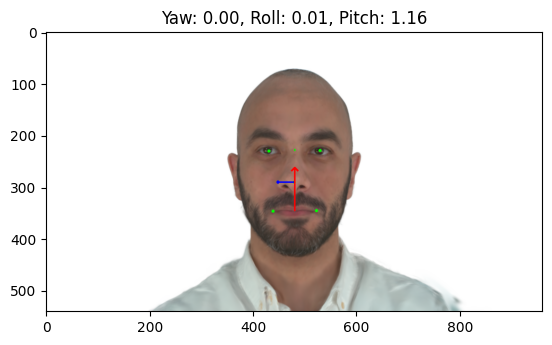

In [ ]:
first_render = cv2.imread(renders[0])
bboxes, kpss = detect_model.detect(first_render, max_num=1)
landmarks = kpss[0]
for (x, y) in landmarks:
    cv2.circle(first_render, (int(x), int(y)), 3, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(first_render, cv2.COLOR_BGR2RGB))
# arrow for yaw
cv2.arrowedLine(first_render, (int(landmarks[2][0]), int(landmarks[2][1])), 
                (int(landmarks[2][0] + 50 * (yaw_ratios[0] - mean_yaw) / std_yaw), 
                 int(landmarks[2][1])), (255, 0, 0), 2)
# arrow for roll
cv2.arrowedLine(first_render, (int((landmarks[0][0] + landmarks[1][0]) / 2), int((landmarks[0][1] + landmarks[1][1]) / 2)), 
                (int((landmarks[0][0] + landmarks[1][0]) / 2), 
                 int((landmarks[0][1] + landmarks[1][1]) / 2 + 50 * (roll_ratios[0] - mean_roll) / std_roll)), (0, 255, 0), 2)
# arrow for pitch
cv2.arrowedLine(first_render, (int((landmarks[3][0] + landmarks[4][0]) / 2), int((landmarks[3][1] + landmarks[4][1]) / 2)), 
                (int((landmarks[3][0] + landmarks[4][0]) / 2), 
                 int((landmarks[3][1] + landmarks[4][1]) / 2 - 50 * (pitch_ratios[0] - mean_pitch) / std_pitch)), (0, 0, 255), 2)
plt.title(f'Yaw: {yaw_ratios[0]:.2f}, Roll: {roll_ratios[0]:.2f}, Pitch: {pitch_ratios[0]:.2f}')
plt.imshow(cv2.cvtColor(first_render, cv2.COLOR_BGR2RGB))
plt.show()

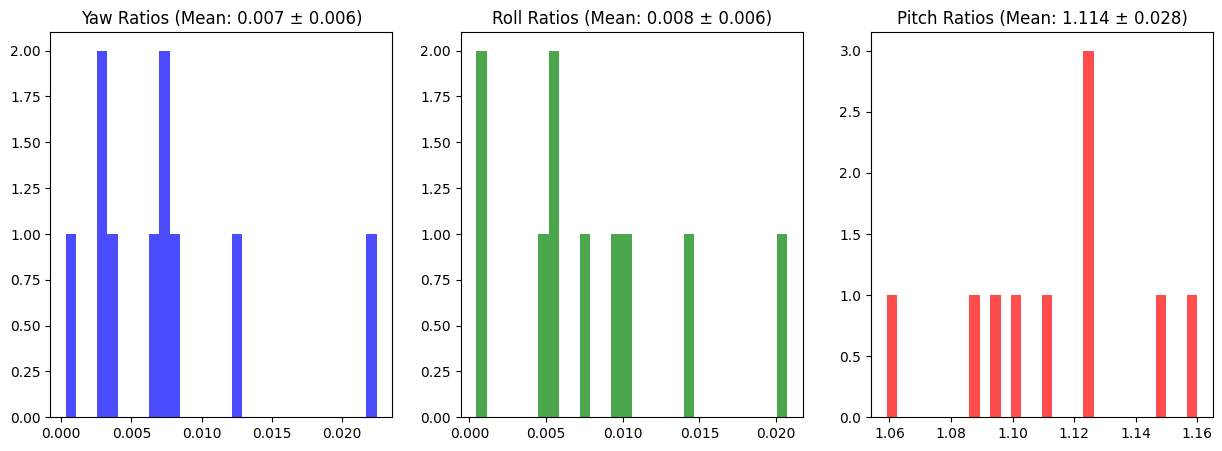

In [16]:
plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(yaw_ratios, bins=30, color='blue', alpha=0.7)
plt.title('Yaw Ratios (Mean: {:.3f} ± {:.3f})'.format(mean_yaw, std_yaw))
plt.subplot(1, 3, 2)
plt.hist(roll_ratios, bins=30, color='green', alpha=0.7)
plt.title('Roll Ratios (Mean: {:.3f} ± {:.3f})'.format(mean_roll, std_roll))
plt.subplot(1, 3, 3)
plt.hist(pitch_ratios, bins=30, color='red', alpha=0.7)
plt.title('Pitch Ratios (Mean: {:.3f} ± {:.3f})'.format(mean_pitch, std_pitch))
plt.show()

In [57]:
# specify thresholds based on mean and std, we need slightly relaxed bounds as real images vary more
YAW_BOUNDS = (mean_yaw - 10 * std_yaw, mean_yaw + 10 * std_yaw)
ROLL_BOUNDS = (mean_roll - 10 * std_roll, mean_roll + 10 * std_roll)
PITCH_BOUNDS = (mean_pitch - 3 * std_pitch, mean_pitch + 3 * std_pitch)

### Filter dataset of real photos to find frontal ones

In [ ]:
paths = glob("../datasets/NeRSemble/**/images/*.png", recursive=True)
len(paths)

287600

In [26]:
paths_per_subject = {}
for p in paths:
    subject_id = p.split("/")[7]
    exp_type = p.split("/")[16].split("_")[1]
    if subject_id not in paths_per_subject:
        paths_per_subject[subject_id] = {}
    if exp_type not in paths_per_subject[subject_id]:
        paths_per_subject[subject_id][exp_type] = []
    paths_per_subject[subject_id][exp_type].append(p)

In [43]:
print(paths_per_subject['074'].keys())
print(len(paths_per_subject['074'].keys()))

dict_keys(['EMO-1', 'EMO-2', 'EMO-3', 'EMO-4', 'EXP-2', 'EXP-3', 'EXP-4', 'EXP-5', 'EXP-8', 'EXP-9', 'FREE'])
11


In [65]:
# we have 11 experiment types per subject and want to gather ~20 images per subject, 
# then we will select 2 frontal images per experiment type
frontal_faces_per_subject = {sid: [] for sid in paths_per_subject.keys()}

In [ ]:
for subject_id, exp_types in paths_per_subject.items():
    for exp_type_idx, exp_type in enumerate(exp_types.keys()):
        subpaths = paths_per_subject[subject_id][exp_type]
        
        for idx, path in enumerate(tqdm(subpaths, desc=f"Processing subject {subject_id} - {exp_type}")):
            # skip near-duplicates, process every 3rd image
            if idx % 3 != 0:
                continue
            
            # only gather 2 images per subject per experiment type
            if len(frontal_faces_per_subject[subject_id]) >= 2 * (exp_type_idx + 1):
                break
            
            yaw_ratio, roll_ratio, pitch_ratio = estimate_face_pos(Path(path))
            if yaw_ratio is None:
                continue
            if not (YAW_BOUNDS[0] <= yaw_ratio <= YAW_BOUNDS[1]):
                continue
            if not (ROLL_BOUNDS[0] <= roll_ratio <= ROLL_BOUNDS[1]):
                continue
            if not (PITCH_BOUNDS[0] <= pitch_ratio <= PITCH_BOUNDS[1]):
                continue

            # store the image path if frontal face is detected
            frontal_faces_per_subject[subject_id].append(path)

Subject 074 - Collected 22 frontal face images.


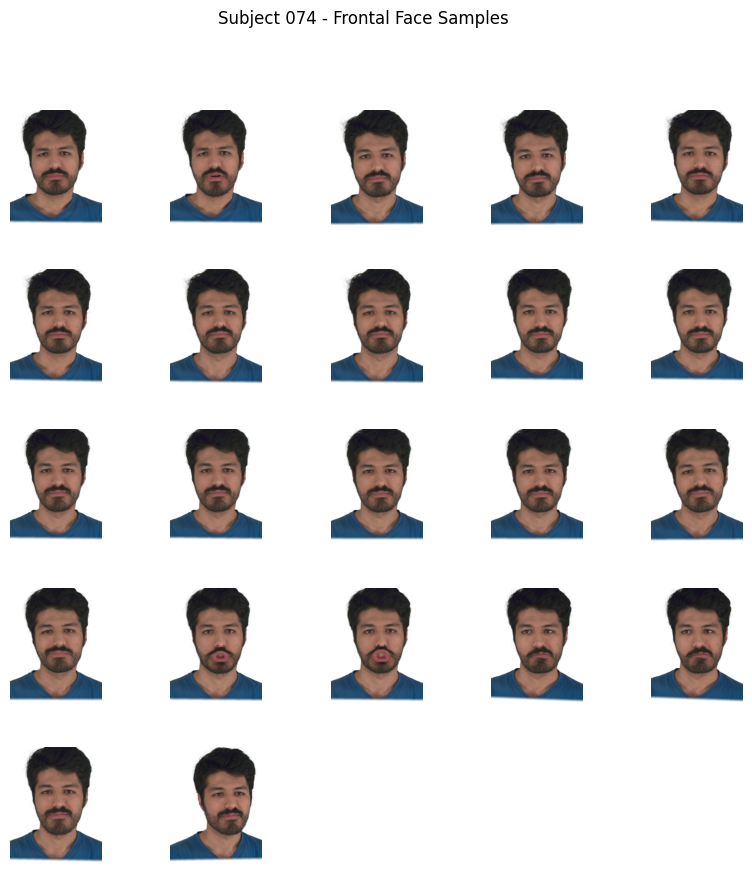

Subject 104 - Collected 22 frontal face images.


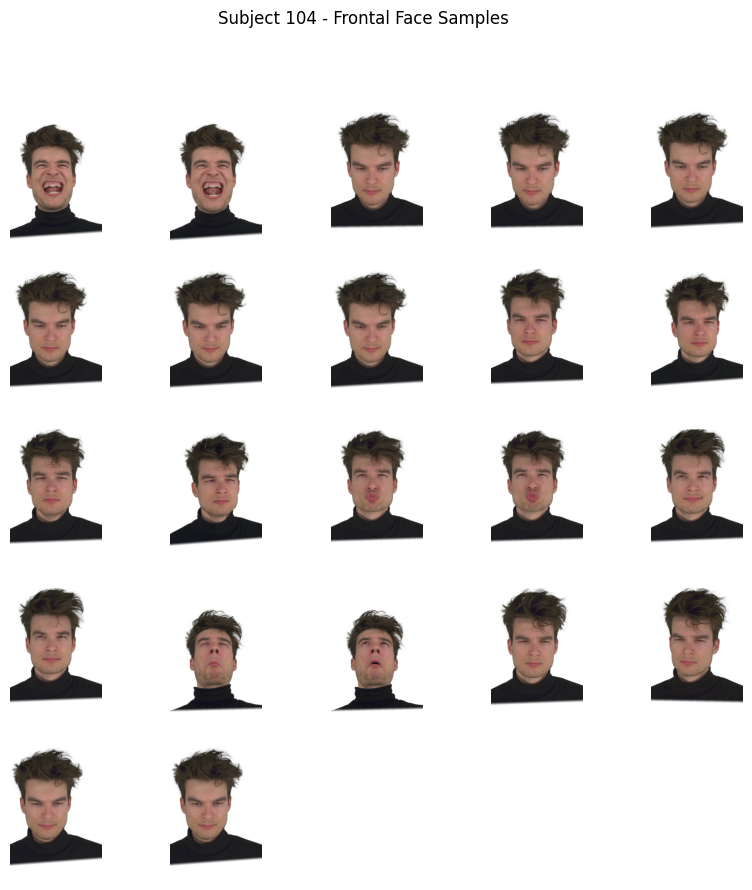

Subject 140 - Collected 22 frontal face images.


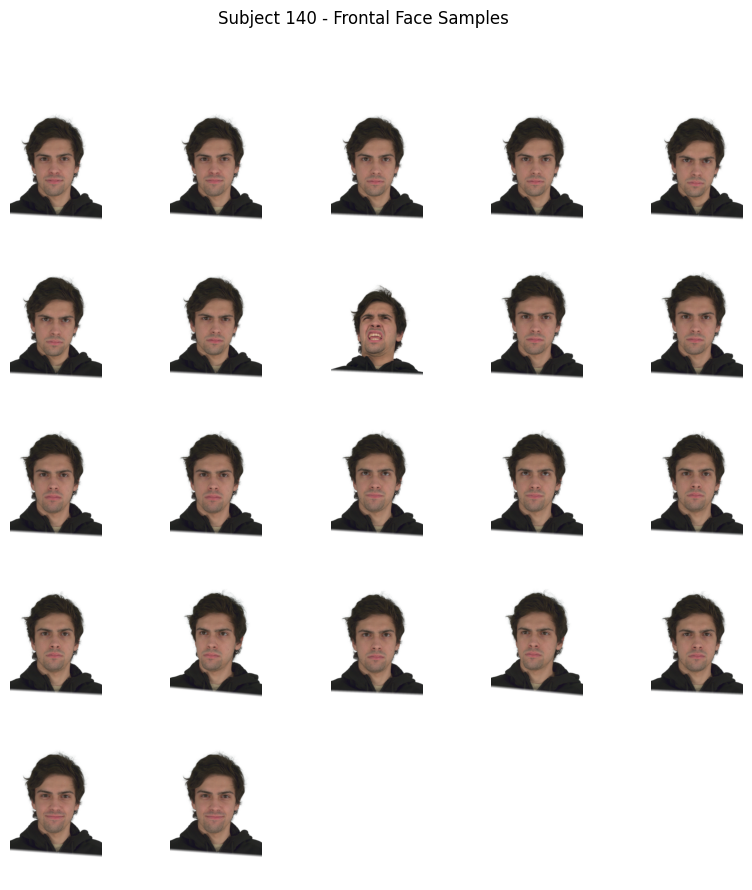

Subject 218 - Collected 22 frontal face images.


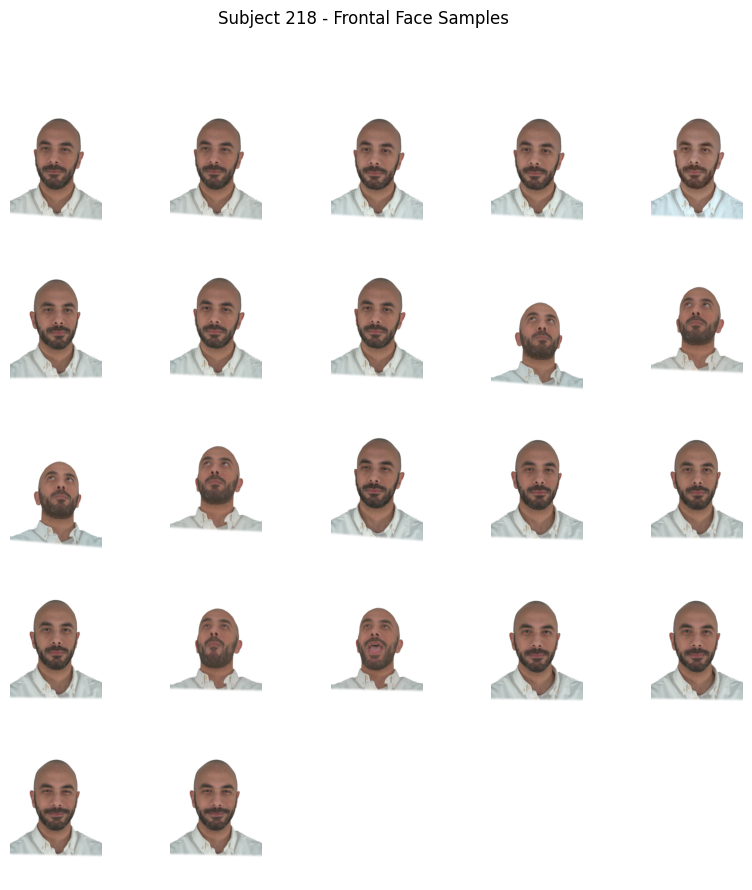

Subject 253 - Collected 22 frontal face images.


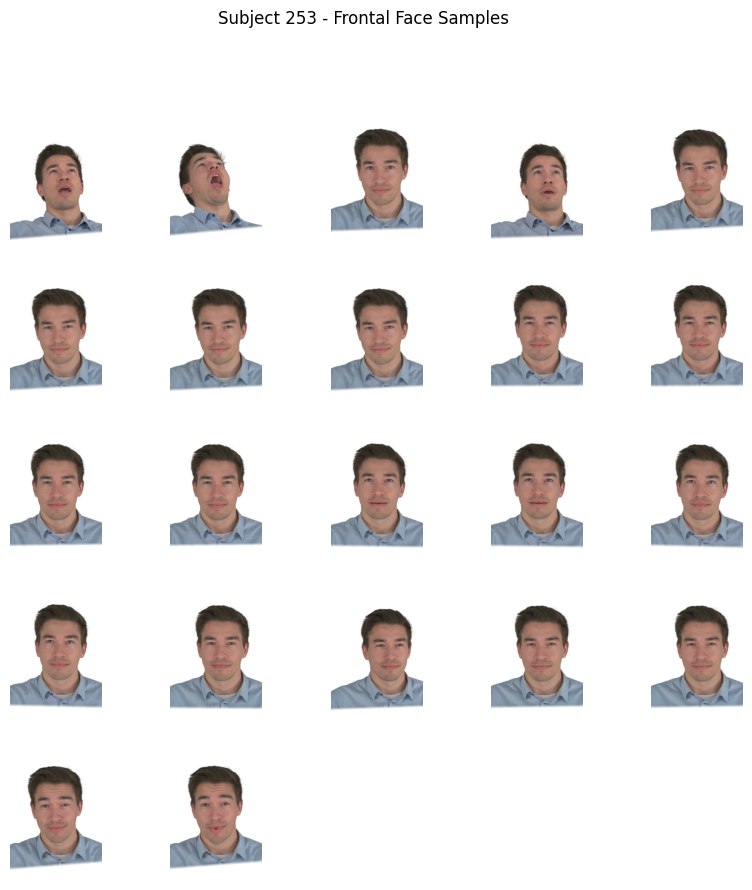

Subject 264 - Collected 22 frontal face images.


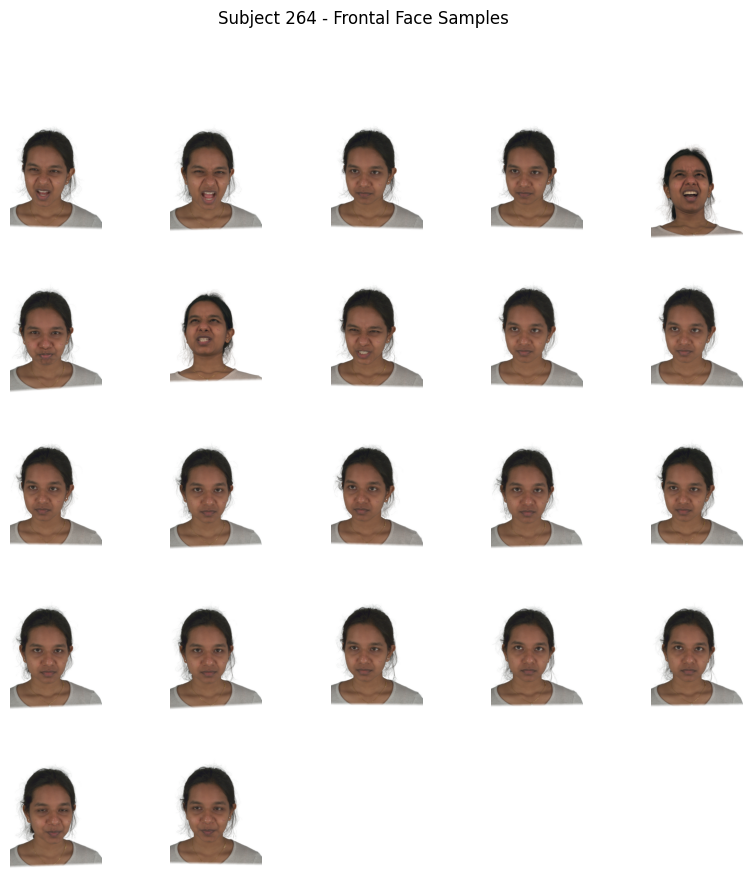

Subject 302 - Collected 22 frontal face images.


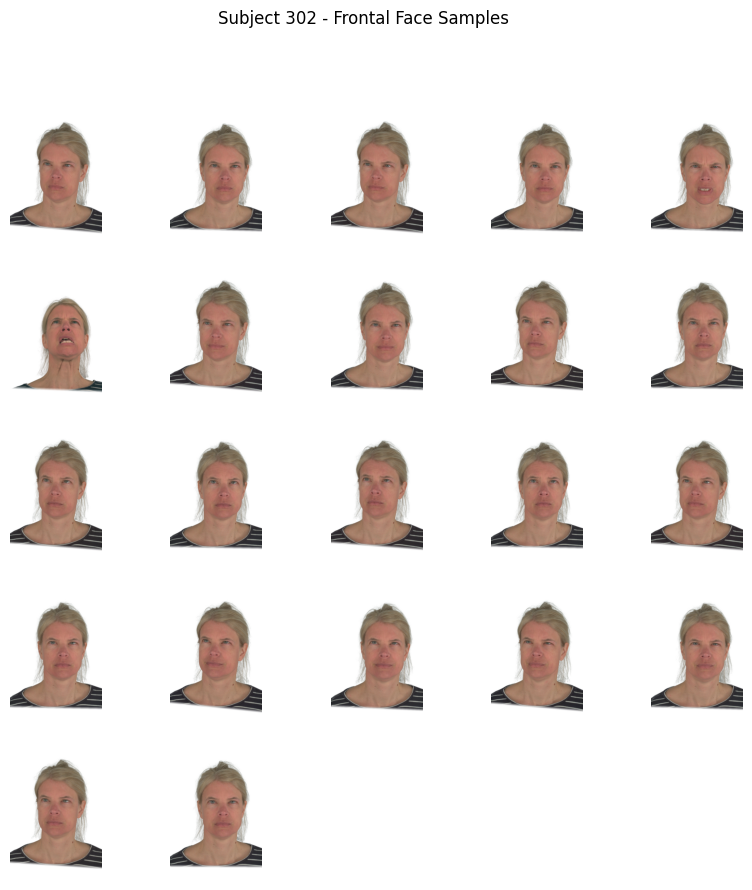

Subject 304 - Collected 22 frontal face images.


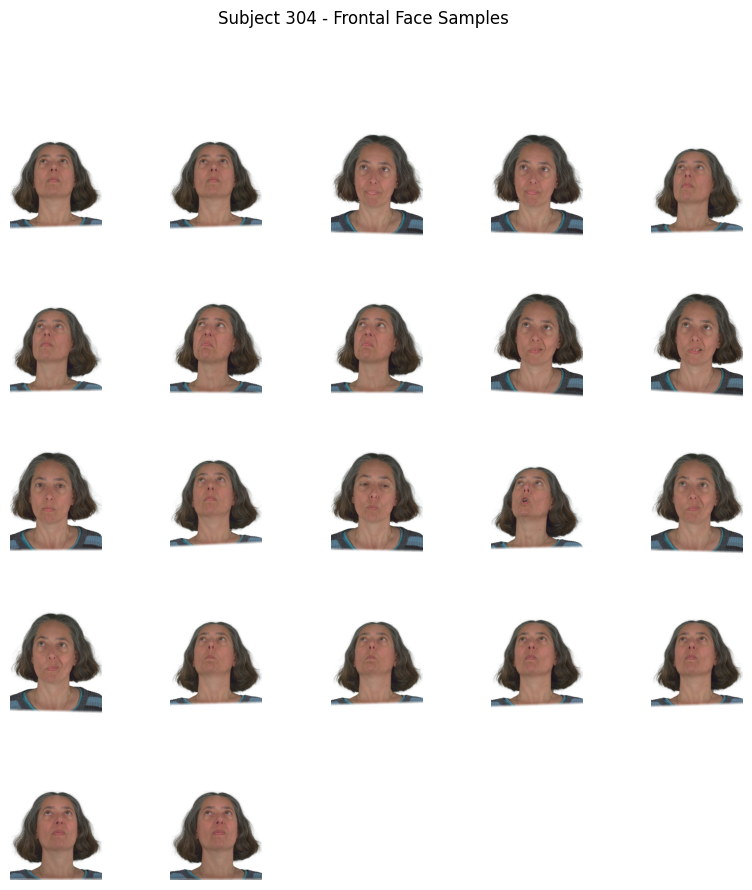

Subject 306 - Collected 22 frontal face images.


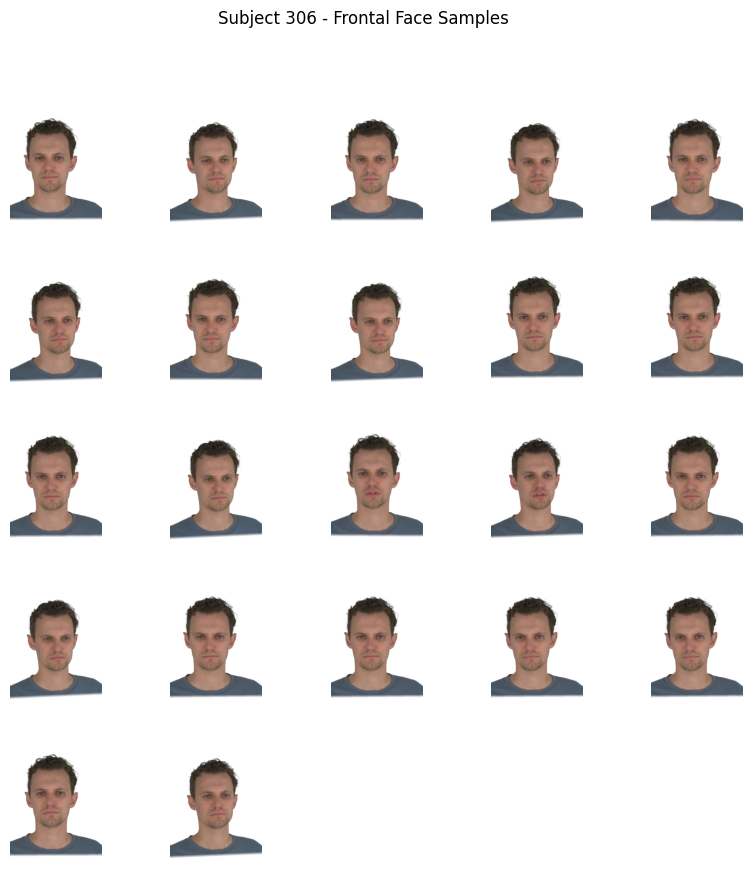

Subject 460 - Collected 22 frontal face images.


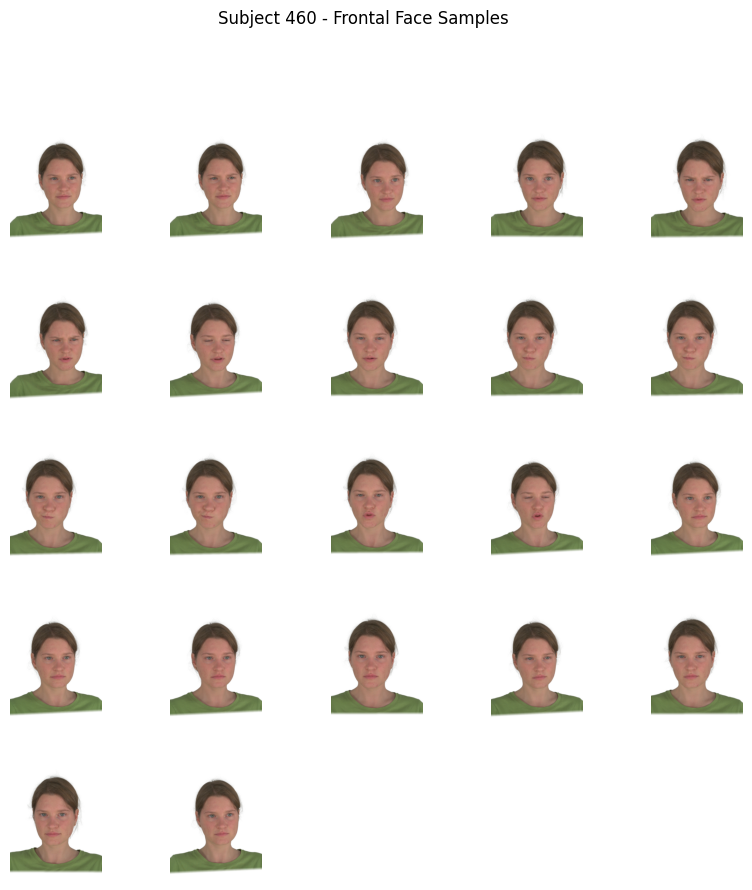

In [74]:
for subject_id, face_paths in frontal_faces_per_subject.items():
    print(f"Subject {subject_id} - Collected {len(face_paths)} frontal face images.")
    
    # Display all images per subject 5 per row
    plt.figure(figsize=(10, 10))
    for i, face_path in enumerate(face_paths):
        img = cv2.imread(face_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot((len(face_paths) + 4) // 5, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.suptitle(f'Subject {subject_id} - Frontal Face Samples')
    plt.show()

In [ ]:
# copy images to datasets/NeRSembleGT/images/{subject_id}/
import os
import shutil
output_base_dir = "../datasets/NeRSembleGT/images/"

for subject_id, paths in frontal_faces_per_subject.items():
    subject_dir = os.path.join(output_base_dir, subject_id)
    os.makedirs(subject_dir, exist_ok=True)
    for idx, path in enumerate(paths):
        # copy and rename to idx
        filename = os.path.basename(path)
        dest_path = os.path.join(subject_dir, f"{idx}_{filename}")
        shutil.copy2(path, dest_path)